In [1]:
!pip install torch torchvision

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations with resizing to 224x224 for AlexNet compatibility
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import torchvision.models as models
import torch.nn as nn

# Load ResNet-18 model and modify for CIFAR-10
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # CIFAR-10 has 10 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [4]:
# Load AlexNet model and modify for CIFAR-10
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)  # CIFAR-10 has 10 classes
alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 146MB/s]


In [5]:
import torch.optim as optim
import torch.nn.functional as F

# Training function
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(trainloader)

# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(testloader), accuracy

In [6]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=learning_rate)
optimizer_alexnet = optim.Adam(alexnet.parameters(), lr=learning_rate)

# Initialize lists to store losses and accuracies for both models
resnet_train_losses = []
resnet_val_losses = []
resnet_val_accuracies = []

alexnet_train_losses = []
alexnet_val_losses = []
alexnet_val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Train ResNet-18
    resnet_train_loss = train(resnet18, trainloader, optimizer_resnet, criterion, device)
    resnet_val_loss, resnet_val_accuracy = evaluate(resnet18, testloader, criterion, device)

    # Store loss and accuracy for ResNet-18
    resnet_train_losses.append(resnet_train_loss)
    resnet_val_losses.append(resnet_val_loss)
    resnet_val_accuracies.append(resnet_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], ResNet18 Loss: {resnet_train_loss:.4f}, Val Loss: {resnet_val_loss:.4f}, Val Acc: {resnet_val_accuracy:.2f}%')

    # Train AlexNet
    alexnet_train_loss = train(alexnet, trainloader, optimizer_alexnet, criterion, device)
    alexnet_val_loss, alexnet_val_accuracy = evaluate(alexnet, testloader, criterion, device)

    # Store loss and accuracy for AlexNet
    alexnet_train_losses.append(alexnet_train_loss)
    alexnet_val_losses.append(alexnet_val_loss)
    alexnet_val_accuracies.append(alexnet_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], AlexNet Loss: {alexnet_train_loss:.4f}, Val Loss: {alexnet_val_loss:.4f}, Val Acc: {alexnet_val_accuracy:.2f}%')



Epoch [1/10], ResNet18 Loss: 0.5516, Val Loss: 0.4149, Val Acc: 86.08%
Epoch [1/10], AlexNet Loss: 1.8204, Val Loss: 1.6513, Val Acc: 41.35%
Epoch [2/10], ResNet18 Loss: 0.3198, Val Loss: 0.3395, Val Acc: 88.49%
Epoch [2/10], AlexNet Loss: 1.3561, Val Loss: 1.1628, Val Acc: 58.39%
Epoch [3/10], ResNet18 Loss: 0.2239, Val Loss: 0.3347, Val Acc: 88.69%
Epoch [3/10], AlexNet Loss: 1.1226, Val Loss: 1.0401, Val Acc: 63.52%
Epoch [4/10], ResNet18 Loss: 0.1625, Val Loss: 0.3583, Val Acc: 88.42%
Epoch [4/10], AlexNet Loss: 1.0002, Val Loss: 1.0387, Val Acc: 65.54%
Epoch [5/10], ResNet18 Loss: 0.1293, Val Loss: 0.4507, Val Acc: 87.63%
Epoch [5/10], AlexNet Loss: 0.9080, Val Loss: 0.8758, Val Acc: 70.08%
Epoch [6/10], ResNet18 Loss: 0.0993, Val Loss: 0.3696, Val Acc: 89.61%
Epoch [6/10], AlexNet Loss: 0.8392, Val Loss: 0.8481, Val Acc: 71.68%
Epoch [7/10], ResNet18 Loss: 0.0834, Val Loss: 0.4030, Val Acc: 89.25%
Epoch [7/10], AlexNet Loss: 0.7964, Val Loss: 0.8118, Val Acc: 72.95%
Epoch [8/10],

NameError: name 'plt' is not defined

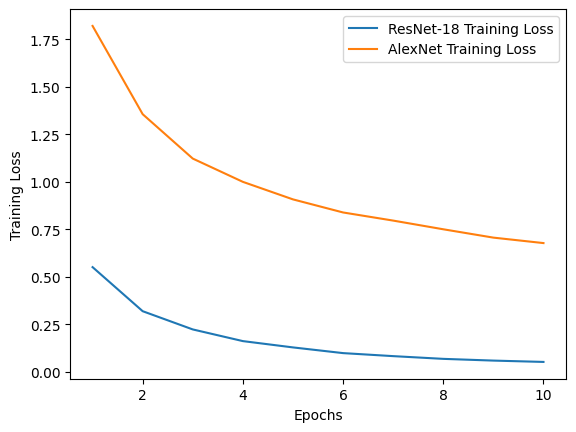

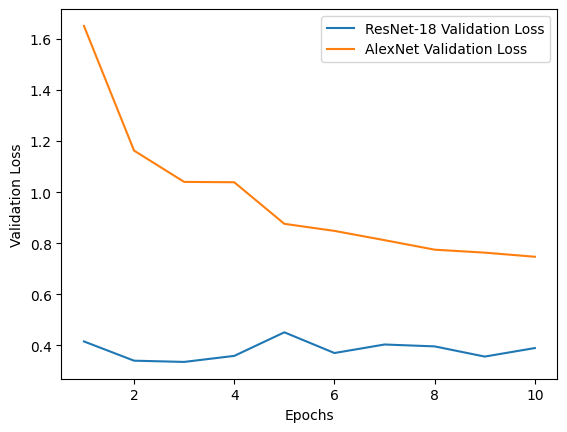

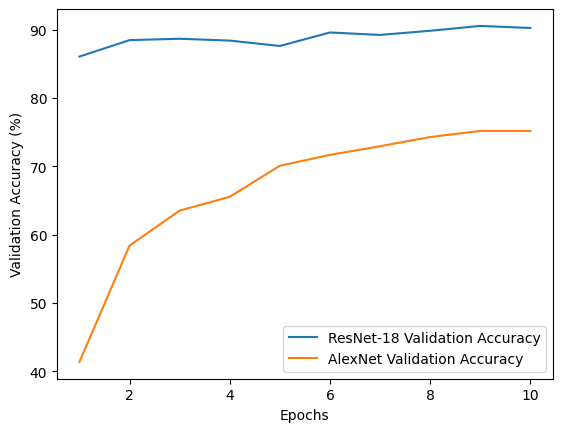

In [7]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

epochs = range(1, num_epochs + 1)

# Plot Training Loss
plt.figure()
plt.plot(epochs, resnet_train_losses, label='ResNet-18 Training Loss')
plt.plot(epochs, alexnet_train_losses, label='AlexNet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Plot Validation Loss
plt.figure()
plt.plot(epochs, resnet_val_losses, label='ResNet-18 Validation Loss')
plt.plot(epochs, alexnet_val_losses, label='AlexNet Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure()
plt.plot(epochs, resnet_val_accuracies, label='ResNet-18 Validation Accuracy')
plt.plot(epochs, alexnet_val_accuracies, label='AlexNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()